# Data exploration notebook

> This notebook is dedicated to experimenting with data.

The project aims to build a universal image upscaler. Unlike domain-specific SR models (e.g., for medical imaging or satellite photos), our system must generalize across a wide range of textures, lighting conditions, and semantic content, such as:
- human faces and skin details,
- natural elements (foliage, water, sky),
- man-made structures (buildings, roads, text),
- textiles and fine patterns.

To achieve this, the **training data must be diverse, high-quality, and representative of real-world image distributions**.

## Dataset selection

We consider the following publicly available datasets commonly used in super-resolution research:

| **Dataset** | **Images** | **Resolution** | **Content type** | **Note** | **License** |
| :---: | :---: | :---: | :---: | :---: | :---: |
| DIV2K | 800 (train) + 100 (valid) | ~2K | General: nature, urban, people, objects | Standard benchmark in SR literature | CC BY 4.0 |
| FlickrR2K | 2650 | Varies (mostly HD+) | General web photos | More diverse compared to DIV2K but less curated | Unknown |
| FFHQ | 70000 | 1024 $ \times $ 1024 | Human faces | Complements general datasets for face detail | CC BY-NC-SA 4.0 |

Sample images from DIV2K and FFHQ datasets are shown below. There are a bit more images in the `data` directory of the project.

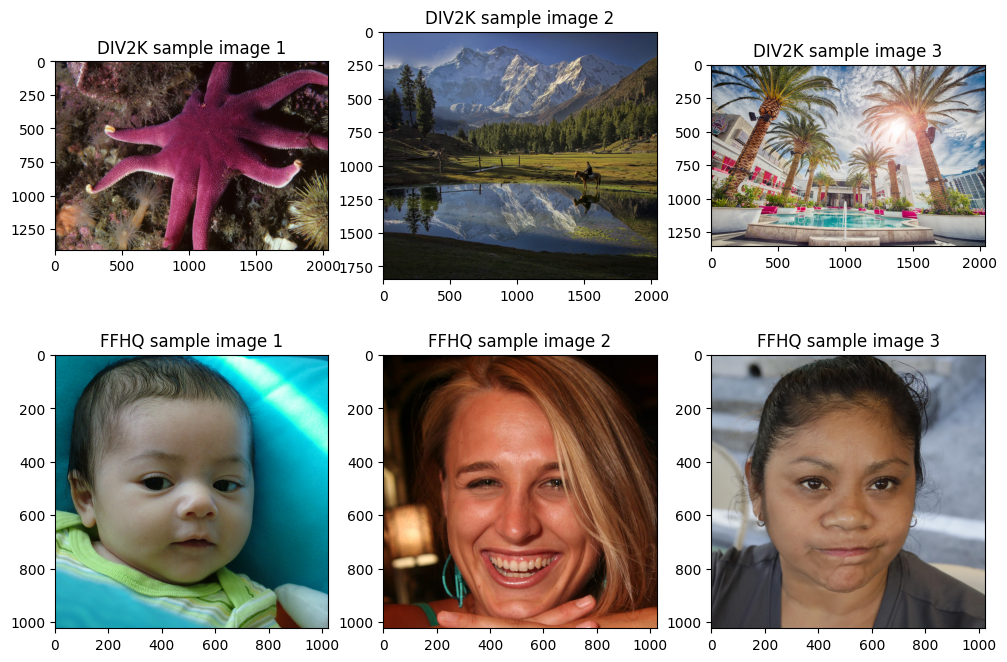

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

fig, images = plt.subplots(2, 3, figsize=(12, 8))

# Visualizing the very first 3 images from DIV2K and FFHQ
for image_num in range(3):
    div2k_sample = np.asarray(Image.open(f"../data/div2k_samples/000{str(image_num + 1)}.png"))
    ffhq_sample = np.asarray(Image.open(f"../data/ffhq_samples/0000{str(image_num)}.png"))
    
    images[0][image_num].imshow(div2k_sample)
    images[0][image_num].set_title(f"DIV2K sample image {image_num + 1}")
    
    images[1][image_num].imshow(ffhq_sample)
    images[1][image_num].set_title(f"FFHQ sample image {image_num + 1}")

To balance diversity, quality, and practical feasibility, we propose the following **training set: full DIV2K training set (800 HR images) as a primary source and the first 100 images of FFHQ for face-specific augmentation**. We explicitly exclude Flickr2K due to ambiguous licensing and potential copyright concerns

This yields a total of 900 high-quality images — a dataset size that is sufficient for training lightweight CNNs (e.g., SRCNN) from scratch and adequate for fine-tuning more complex architectures if needed.

## Data preparation

Super-resolution is a paired learning task: for each high-resolution (HR) image, we must generate a corresponding low-resolution (LR) counterpart.

This synthetic degradation ensures:
1. Full control over the ground truth.
2. Compatibility with pretrained models (which assume bicubic degradation).
3. Reproducibility of training and evaluation.

We create LR images by downsampling HR images using bicubic interpolation with a scale factor of x4.

**Scale factor selection**

| **Scale** | **Pros** | **Cons** | **Common in literature?** |
| :---: | :---: | :---: | :---: |
| x2 | Fast training, high PSNR | Little-to-no difference with interpolation | Yes, as a benchmark |
| x4 | "Standard" for pretrained models, high quality | Requires more time than interpolation | Yes |
| x8 | Extremely high quality | Low stability, extremely noisy LR, requires complex model architecture | Rarely 

**No additional preprocessing is applied to the original datasets**, as DIV2K and FFHQ are already high-quality, clean, and well-aligned for SR tasks.

**Baseline Method: Bicubic Interpolation.**

It is important to note that bicubic interpolation is not a learnable model — it is a classical signal processing technique used as a non-learned baseline. In our pipeline it serves as the degradation operator used for training and also acts as the simplest upscaling method during inference.

All neural approaches (SRCNN, ESRGAN, SwinIR) are evaluated relative to this baseline, both quantitatively (PSNR/SSIM) and qualitatively.

## Patch-based training

Due to memory constraints on GPUs and the large size of HR images in DIV2K (~2K resolution), we adopt a patch-based training strategy: training is performed on randomly cropped 96 $ \times $ 96 HR patches (and corresponding 24 $ \times $ 24 LR patches). This approach increases the effective size of the training set and allows models to fit into limited GPU memory.

Note: full-image inference is still performed at test time — patching is used only during training.

## Metrics

To assess the performance of upscaling methods, we adopt three widely used complementary metrics: PSNR, SSIM and LPIPS.

| **Metric** | **Measurement** | **Strengths** | **Limitations** |
| :---: | :---: | :---: | :---: |
| PSNR (Peak Signal-to-Noise Ratio) | Pixel-wise fidelity (MSE-based) | Simple, fast, correlates with reconstruction accuracy | Poor correlation with human perception, ignores structural details |
| SSIM (Structural Similarity Index) | Structural similarity (luminance, contrast, structure) | Better perceptual alignment than PSNR | Still limited on texture realism |
| LPIPS (Learned Perceptual Image Patch Similarity) | Deep feature distance (using pretrained VGG)| Strong correlation with human judgment; captures texture realism | Computationally heavy |

PSNR/SSIM are standard in classical and CNN-based works (e.g., SRCNN).
LPIPS is essential for evaluating GAN-based methods (e.g., ESRGAN), which often sacrifice PSNR for perceptual quality.

All metrics are computed between the model’s output and the original HR image, using the bicubically downsampled LR as input. This ensures a fair, reproducible evaluation protocol aligned with DIV2K benchmarks.

# TODO: FORMULAS AND TEXT CORRECTION; BETTER FORMALIZATION

# Conclusion

We have selected a legally compliant, high-quality dataset composition (DIV2K + FFHQ) suitable for training and evaluating a universal image super-resolution system. The data preparation pipeline — bicubic downsampling to ×4, patch-based sampling, and no additional preprocessing — aligns with established protocols in the literature. Evaluation will be performed using complementary metrics (PSNR, SSIM, LPIPS) against the bicubic baseline. This foundation enables fair comparison of classical, CNN-based, GAN, and transformer approaches in the next stage of the project.